In [1]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
from sklearn import model_selection
import matplotlib.pyplot as plt 
from keras import layers
from keras.models import Sequential
from livelossplot.keras import PlotLossesCallback
from IPython.display import clear_output

In [2]:
filename = 'MarmousiModel2.mat'#filename = 'MarmousiModel2_Changed.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [3]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']

WAVELET = marmousi_cube['wavelet']

### Parameters 

In [4]:
n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,80)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)
#valid_wells_loc = np.random.shuffle( np.arange(pimpedance.shape[1]))
BATCH_SIZE = 10
noise_dim = 2800#700
IMG_SHAPE = (2800,1,1)#(700,1,1)



### Normalizar Sismica

In [5]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)

In [6]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)

### Visualizar estatísticas

In [7]:
'''data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()'''

"data_info = pd.DataFrame(zip(seismic_norm.flatten(),\n                             pimpedance.flatten()),\n                         columns=['Seismic CL Stats','PImp CL Stats'])\ndata_info.describe()"

### Preparar os Dados

In [8]:
X_train = np.transpose(seismic_norm[:,train_wells_loc])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc])
X_train = np.expand_dims(X_train,axis=(2,3))
Y_train = np.expand_dims(Y_train,axis=(2,3))

X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=(2,3))
Y_valid = np.expand_dims(Y_valid,axis=(2,3))

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=(2,3))
Y_test = np.expand_dims(Y_test,axis=(2,3))


In [9]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

print('     IP (Y_test) shape: ',Y_test.shape)
print('seismic (X_test) shape: ',X_test.shape)


     IP (Y_train) shape:  (171, 2800, 1, 1)
seismic (X_train) shape:  (171, 2800, 1, 1)
     IP (Y_valid) shape:  (1343, 2800, 1, 1)
seismic (X_valid) shape:  (1343, 2800, 1, 1)
     IP (Y_test) shape:  (13601, 2800, 1, 1)
seismic (X_test) shape:  (13601, 2800, 1, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

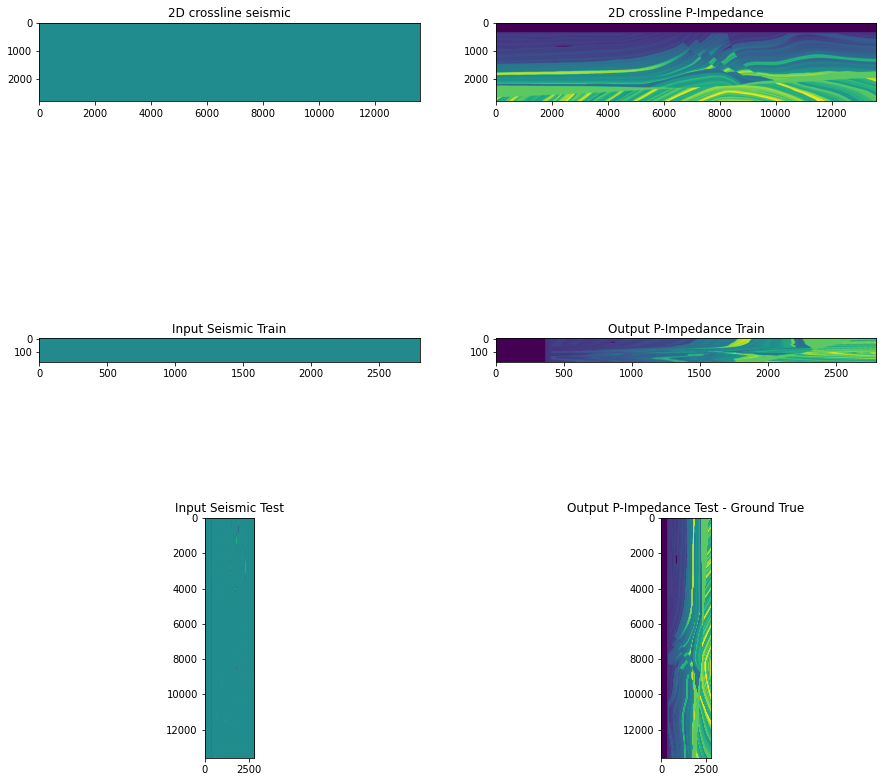

In [10]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))


axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")


axes1[1,0].imshow(X_train[:,:,0,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Criação e Configuração da Rede

### Create the generator


In [11]:
def ResBlock(inputRB):
    RB0 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(inputRB)
    RB = layers.BatchNormalization()(RB0)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,inputRB])
    RB = layers.ReLU()(RB)
    return (RB)

In [12]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

f_model = get_generator_model()

f_model.summary()
#plot_model(f_model, show_shapes=True, show_layer_names=False)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2800, 1, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2800, 1, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 2800, 1, 1)   0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2800, 1, 16)  4816        re_lu[0][0]                      
______________________________________________________________________________________________

In [24]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='g_loss', patience=200)
'''callback =  tf.keras.callbacks.EarlyStopping(monitor='loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=300)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='forward_model/autosaved_modeln_1d.hdf5', 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')'''

checkpoint = keras.callbacks.ModelCheckpoint(filepath='forward_model/autosaved_modeln_1d.hdf5',
                                             monitor='val_mse',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='min')


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        plt.plot(self.x[-100:], self.losses[-100:], label="loss")
        plt.plot(self.x[-100:], self.val_losses[-100:], label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [25]:
f_model = get_generator_model()

In [26]:
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)
#compile model using accuracy to measure model performance
f_model.compile(optimizer=optimizer, loss='mse', metrics='mse')

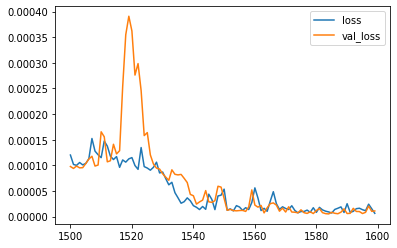


Epoch 01600: val_mse did not improve from 0.00001


In [27]:
## train the model
f_model.fit(Y_train, X_train,
            validation_data=(Y_valid, X_valid),
            epochs=1600,
            verbose=1,
            shuffle=True,
            batch_size=BATCH_SIZE,
            callbacks = [plot_losses,checkpoint])

In [28]:
#f_model.load_weights('forward_model/autosaved_modeln.hdf5')

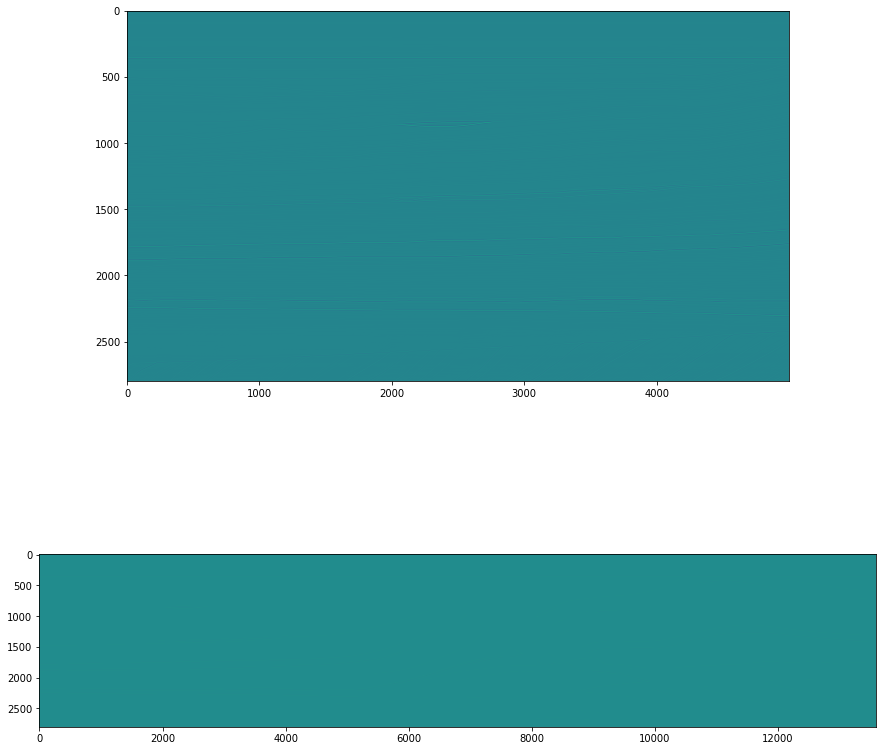

In [29]:
predict = f_model(Y_test[:5000,:,:])
predict = np.transpose(predict[:,:,0,0].numpy())
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
axes1[0].imshow(predict)
axes1[1].imshow(np.transpose(X_test[:,:,0,0]))

In [36]:
save = True
if save:
    # serialize model to JSON
    model_json = f_model.to_json()
    with open("forward_model/modelnorm_2d.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    f_model.save_weights("forward_model/modelnorm_2d.h5")
    print("Saved model to disk")


Saved model to disk


0.0008081381592572838

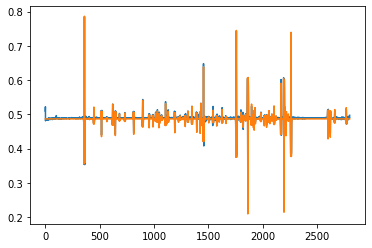

In [35]:
test_trace = np.random.randint(predict.shape[1])
plt.plot(predict[:,test_trace])
plt.plot(X_test[test_trace,:,0]+0)
mse = np.mean((X_test[test_trace,:,0]-predict[:,test_trace])**2)
mse

In [21]:
'''models = []
errors = []
for i in range(20):
    print('- '*7)
    f_model = get_generator_model()
    f_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    f_model.fit(Y_train, X_train,
            validation_data=(Y_valid, X_valid),
            epochs=2000,
            verbose=0,
           batch_size=5,
                
           callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=500)
                
               )
    error_mse = np.mean(((Y_test-f_model(X_test))**2)[:])
    models.append(f_model)
    errors.append(error_mse)
    print('training done, i: {}, loss: {}'.format(i,error_mse))'''
''

''

In [22]:
'''min_value = min(errors)
min_index = errors.index(min_value)
print('best: ',min_index)'''
''

''

In [23]:
'''f_model = models[min_index]'''
''

''